# Environments

## Multi armed bandit

#### Baseline (Random)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# --- Bandit Environment ---
class MultiArmedBandit:
    def __init__(self, k=5):
        # true reward probabilities (unknown to agent)
        self.k = k
        self.probs = torch.rand(k)  # random [0,1] reward chances

    def step(self, action):
        # stochastic reward: 1 with prob p(a), else 0
        reward = torch.bernoulli(self.probs[action])
        return reward.item()

    def optimal_action(self):
        return torch.argmax(self.probs).item()

# --- Policy Network ---
class Policy(nn.Module):
    def __init__(self, k):
        super().__init__()
        self.logits = nn.Parameter(torch.zeros(k))  # parameters for each arm

    def forward(self):
        return torch.softmax(self.logits, dim=0)

    def sample_action(self):
        probs = self.forward()
        dist = torch.distributions.Categorical(probs)
        action = dist.sample()
        return action, dist.log_prob(action)

# --- Training ---
def train_bandit(k=5, steps=1000, lr=0.1):
    env = MultiArmedBandit(k)
    policy = Policy(k)
    optimizer = optim.Adam([policy.logits], lr=lr)

    for t in range(steps):
        action, log_prob = policy.sample_action()
        reward = env.step(action)

        # loss = -reward * log(pi(a)) (policy gradient)
        loss = -reward * log_prob
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (t+1) % 100 == 0:
            probs = policy.forward().detach().numpy()
            print(f"Step {t+1}: probs={probs.round(3)}, reward={reward}")

    print("\nTrue best arm:", env.optimal_action())
    print("Learned best arm:", torch.argmax(policy.forward()).item())

train_bandit()


Step 100: probs=[0.015 0.523 0.024 0.183 0.254], reward=0.0
Step 200: probs=[0.004 0.83  0.01  0.056 0.101], reward=0.0
Step 300: probs=[0.001 0.957 0.003 0.018 0.021], reward=1.0
Step 400: probs=[0.001 0.976 0.002 0.008 0.013], reward=1.0
Step 500: probs=[0.001 0.969 0.001 0.019 0.01 ], reward=1.0
Step 600: probs=[0.001 0.957 0.001 0.03  0.011], reward=0.0
Step 700: probs=[0.001 0.945 0.001 0.047 0.006], reward=1.0
Step 800: probs=[0.    0.983 0.    0.014 0.003], reward=1.0
Step 900: probs=[0.    0.949 0.001 0.042 0.007], reward=0.0
Step 1000: probs=[0.    0.974 0.    0.022 0.004], reward=1.0

True best arm: 1
Learned best arm: 1


#### PMPO

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim

# --- Bandit Environment ---
class MultiArmedBandit:
    def __init__(self, k=5):
        self.k = k
        self.probs = torch.rand(k)  # true unknown reward probabilities

    def step(self, action):
        reward = torch.bernoulli(self.probs[action])
        return reward.item()

    def optimal_action(self):
        return torch.argmax(self.probs).item()

# --- Policy Network ---
class Policy(nn.Module):
    def __init__(self, k):
        super().__init__()
        self.logits = nn.Parameter(torch.zeros(k))

    def forward(self):
        return torch.softmax(self.logits, dim=0)

# --- KL-aware PB-MPO Update ---
def pbmop_update(policy, preferences, eta=0.1):
    """
    preferences: list of (a1, a2) tuples where a1 is preferred over a2
    eta: temperature controlling softness of target policy
    """
    k = policy.logits.shape[0]

    # --- Compute preference scores ---
    scores = torch.zeros(k)
    for a1, a2 in preferences:
        scores[a1] += 1  # count how often each action is preferred

    # --- Soft target policy q(a) ---
    with torch.no_grad():
        q = policy.forward() * torch.exp(scores / eta)
        q = q / q.sum()  # normalize

    # --- KL divergence loss KL(q || pi) ---
    pi = policy.forward()
    loss = torch.sum(q * (torch.log(q + 1e-8) - torch.log(pi + 1e-8)))
    return loss

# --- Evaluation functions ---
def evaluate_policy(env, policy, steps=100):
    total_reward = 0
    for _ in range(steps):
        probs = policy.forward()
        action = torch.distributions.Categorical(probs).sample()
        total_reward += env.step(action)
    return total_reward / steps

def preference_consistency(env, policy, pairs=100):
    correct = 0
    for _ in range(pairs):
        a1 = torch.randint(0, env.k, (1,)).item()
        a2 = torch.randint(0, env.k, (1,)).item()
        r1 = env.step(a1)
        r2 = env.step(a2)
        preferred = a1 if r1 >= r2 else a2
        chosen = torch.argmax(policy.forward()).item()
        if chosen == preferred:
            correct += 1
    return correct / pairs

# --- Training Loop ---
def train_bandit_pbmop(k=5, steps=1000, lr=0.05, batch_size=10, eta=0.1):
    env = MultiArmedBandit(k)
    policy = Policy(k)
    optimizer = optim.Adam([policy.logits], lr=lr)

    for t in range(steps):
        # --- Sample preference pairs ---
        preferences = []
        for _ in range(batch_size):
            a1 = torch.randint(0, k, (1,)).item()
            a2 = torch.randint(0, k, (1,)).item()
            r1 = env.step(a1)
            r2 = env.step(a2)
            if r1 >= r2:
                preferences.append((a1, a2))
            else:
                preferences.append((a2, a1))

        # --- PB-MPO update ---
        loss = pbmop_update(policy, preferences, eta=eta)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # --- Evaluation every 100 steps ---
        if (t + 1) % 100 == 0:
            probs = policy.forward().detach().numpy()
            avg_reward = evaluate_policy(env, policy, steps=100)
            consistency = preference_consistency(env, policy, pairs=100)
            print(f"Step {t+1}: probs={probs.round(3)}, avg_reward={avg_reward:.3f}, pref_consistency={consistency:.3f}")

    print("\nTrue best arm:", env.optimal_action())
    print("Learned best arm:", torch.argmax(policy.forward()).item())

# --- Run training ---
train_bandit_pbmop()


Step 100: probs=[0.167 0.063 0.114 0.263 0.392], avg_reward=0.620, pref_consistency=0.210
Step 200: probs=[0.251 0.097 0.1   0.122 0.429], avg_reward=0.530, pref_consistency=0.360
Step 300: probs=[0.15  0.093 0.06  0.245 0.452], avg_reward=0.640, pref_consistency=0.250
Step 400: probs=[0.161 0.098 0.111 0.202 0.429], avg_reward=0.600, pref_consistency=0.290
Step 500: probs=[0.196 0.077 0.193 0.173 0.36 ], avg_reward=0.540, pref_consistency=0.250
Step 600: probs=[0.216 0.072 0.132 0.25  0.329], avg_reward=0.610, pref_consistency=0.270
Step 700: probs=[0.142 0.074 0.086 0.228 0.47 ], avg_reward=0.630, pref_consistency=0.320
Step 800: probs=[0.181 0.081 0.091 0.204 0.443], avg_reward=0.650, pref_consistency=0.260
Step 900: probs=[0.153 0.071 0.113 0.206 0.458], avg_reward=0.670, pref_consistency=0.310
Step 1000: probs=[0.258 0.073 0.071 0.155 0.443], avg_reward=0.570, pref_consistency=0.360

True best arm: 4
Learned best arm: 4


## Map Exploration

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

class MapEnvWithObstacles:
    """
    Grid-world map exploration with obstacles and penalties.
    """
    def __init__(self, size=5, num_obstacles=3, num_penalties=2, seed=42):
        np.random.seed(seed)
        self.size = size
        self.num_obstacles = num_obstacles
        self.num_penalties = num_penalties
        self.reset()

    def reset(self):
        # Agent starts at top-left
        self.agent_pos = [0, 0]
        # Track visited cells
        self.visited = np.zeros((self.size, self.size), dtype=np.float32)
        self.visited[0, 0] = 1.0

        # Place obstacles randomly (cannot step on)
        self.obstacles = np.zeros((self.size, self.size), dtype=np.bool_)
        free_cells = [(i, j) for i in range(self.size) for j in range(self.size) if (i,j)!=(0,0)]
        obstacle_cells = np.random.choice(len(free_cells), self.num_obstacles, replace=False)
        for idx in obstacle_cells:
            x, y = free_cells[idx]
            self.obstacles[x, y] = True

        # Place penalty cells randomly (negative reward)
        penalty_candidates = [(i, j) for i, j in free_cells if not self.obstacles[i,j]]
        penalty_cells = np.random.choice(len(penalty_candidates), self.num_penalties, replace=False)
        self.penalties = np.zeros((self.size, self.size), dtype=np.bool_)
        for idx in penalty_cells:
            x, y = penalty_candidates[idx]
            self.penalties[x, y] = True

        return self._get_state()

    def _get_state(self):
        # Flattened map: 0=unvisited, 1=visited, 2=agent, 3=obstacle, 4=penalty
        state = np.zeros((self.size, self.size), dtype=np.float32)
        state[self.visited==1] = 1.0
        state[self.obstacles] = 3.0
        state[self.penalties] = 4.0
        x, y = self.agent_pos
        state[x, y] = 2.0
        return torch.tensor(state.flatten())

    def step(self, action):
        """
        Actions: 0=up, 1=down, 2=left, 3=right
        Reward: 1 for new cell, -1 for penalty, 0 otherwise
        """
        x, y = self.agent_pos
        new_x, new_y = x, y

        if action == 0 and x > 0:
            new_x -= 1
        elif action == 1 and x < self.size - 1:
            new_x += 1
        elif action == 2 and y > 0:
            new_y -= 1
        elif action == 3 and y < self.size - 1:
            new_y += 1

        # Check obstacle
        if self.obstacles[new_x, new_y]:
            # Can't move into obstacle
            new_x, new_y = x, y

        self.agent_pos = [new_x, new_y]
        reward = 0.0

        if self.visited[new_x, new_y] == 0:
            reward = 1.0  # reward for exploring
        if self.penalties[new_x, new_y]:
            reward -= 1.0  # negative reward for penalty

        self.visited[new_x, new_y] = 1.0
        return self._get_state(), reward


In [7]:
class MapPolicy(nn.Module):
    def __init__(self, size):
        super().__init__()
        input_dim = size * size
        hidden_dim = 64
        self.fc = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 4)  # 4 actions
        )

    def forward(self, state):
        logits = self.fc(state.float())
        return torch.softmax(logits, dim=-1)

    def sample_action(self, state):
        probs = self.forward(state)
        dist = torch.distributions.Categorical(probs)
        action = dist.sample()
        return action, dist.log_prob(action)

In [8]:
def train_map(env, policy, steps=500, lr=0.01):
    optimizer = optim.Adam(policy.parameters(), lr=lr)

    for t in range(steps):
        state = env.reset()
        total_reward = 0

        for _ in range(env.size * env.size * 3):  # max steps
            action, log_prob = policy.sample_action(state)
            next_state, reward = env.step(action.item())
            total_reward += reward

            # PG update
            loss = -reward * log_prob
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            state = next_state

        if (t+1) % 50 == 0:
            print(f"Episode {t+1}: total_reward={total_reward}")


In [9]:
env = MapEnvWithObstacles(size=5, num_obstacles=3, num_penalties=2)
policy = MapPolicy(size=5)
train_map(env, policy)


Episode 50: total_reward=-68.0
Episode 100: total_reward=2.0
Episode 150: total_reward=2.0
Episode 200: total_reward=-74.0
Episode 250: total_reward=4.0
Episode 300: total_reward=4.0
Episode 350: total_reward=4.0
Episode 400: total_reward=2.0
Episode 450: total_reward=-68.0
Episode 500: total_reward=1.0


In [13]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, colors
from IPython.display import HTML

# ----------------------------
# Environment Setup
# ----------------------------
class MapExplorationEnv:
    def __init__(self, size=6):
        self.size = size
        self.grid = np.zeros((size, size))
        self.reward_map = np.random.choice([-1, 0, 1, 2, 5], size=(size, size), p=[0.1, 0.5, 0.2, 0.15, 0.05])
        self.agent_pos = [0, 0]
        self.total_reward = 0
        self.done = False

    def reset(self):
        self.agent_pos = [0, 0]
        self.total_reward = 0
        self.done = False
        return tuple(self.agent_pos)

    def step(self, action):
        if self.done:
            return self.agent_pos, 0, True

        x, y = self.agent_pos
        if action == 0 and x > 0: x -= 1      # up
        elif action == 1 and x < self.size-1: x += 1  # down
        elif action == 2 and y > 0: y -= 1    # left
        elif action == 3 and y < self.size-1: y += 1  # right

        self.agent_pos = [x, y]
        reward = self.reward_map[x, y]
        self.total_reward += reward
        if (x, y) == (self.size-1, self.size-1):  # goal reached
            self.done = True

        return tuple(self.agent_pos), reward, self.done

    def render_reward_map(self):
        print("🗺️ Reward Map (Coordinates = Reward Values):\n")
        for i in range(self.size):
            for j in range(self.size):
                print(f"({i},{j}): {self.reward_map[i,j]:2d}", end="  ")
            print()
        print("\n🏁 Max Possible Reward Path (ideal):", np.sum(self.reward_map[self.reward_map>0]))

# ----------------------------
# Agent & Training Loop
# ----------------------------
def run_exploration(env, steps=50):
    actions = [0, 1, 2, 3]  # up, down, left, right
    path = [env.reset()]

    for _ in range(steps):
        action = np.random.choice(actions)
        pos, reward, done = env.step(action)
        path.append(pos)
        if done:
            break
    return path

# ----------------------------
# Animation & Visualization
# ----------------------------
def animate_path(env, path):
    fig, ax = plt.subplots(figsize=(5,5))
    cmap = colors.ListedColormap(['#d9d9d9', '#a6d854', '#fc8d62', '#66c2a5', '#e78ac3'])
    norm = colors.BoundaryNorm([-2, -1, 0, 1, 2, 5], cmap.N)

    def update(i):
        ax.clear()
        ax.imshow(env.reward_map, cmap=cmap, norm=norm)
        x, y = path[i]
        ax.scatter(y, x, color='red', s=200, marker='o')
        ax.set_title(f"Step {i+1}/{len(path)} | Pos: {path[i]} | Total Reward: {env.total_reward}")
        ax.grid(True)

    ani = animation.FuncAnimation(fig, update, frames=len(path), interval=600, repeat=False)
    plt.close(fig)
    return HTML(ani.to_jshtml())

# ----------------------------
# Run Everything
# ----------------------------
env = MapExplorationEnv(size=6)
env.render_reward_map()
path = run_exploration(env, steps=40)
animate_path(env, path)


🗺️ Reward Map (Coordinates = Reward Values):

(0,0):  0  (0,1):  5  (0,2):  1  (0,3):  0  (0,4):  0  (0,5):  0  
(1,0): -1  (1,1):  2  (1,2):  1  (1,3):  1  (1,4): -1  (1,5):  5  
(2,0):  2  (2,1):  0  (2,2):  0  (2,3):  0  (2,4):  0  (2,5):  0  
(3,0):  0  (3,1):  0  (3,2):  1  (3,3):  0  (3,4):  0  (3,5):  0  
(4,0):  0  (4,1):  1  (4,2):  0  (4,3):  0  (4,4):  0  (4,5): -1  
(5,0):  1  (5,1):  0  (5,2): -1  (5,3):  2  (5,4):  5  (5,5):  2  

🏁 Max Possible Reward Path (ideal): 29


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


## Map path

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, display

### Map Env

In [ ]:
class MapEnvPref:
    def __init__(self, size=6, num_obstacles=6, num_penalties=3, seed=None):
        self.size = size
        if seed is not None:
            np.random.seed(seed)
            random.seed(seed)
            torch.manual_seed(seed)
        self.num_obstacles = num_obstacles
        self.num_penalties = num_penalties
        self.reset()

    def reset(self):
        self.agent_pos = [0, 0]
        self.visited = np.zeros((self.size, self.size), dtype=np.float32)
        self.visited[0, 0] = 1.0

        # place obstacles (cannot step)
        self.obstacles = np.zeros((self.size, self.size), dtype=bool)
        free = [(i, j) for i in range(self.size) for j in range(self.size) if (i, j) != (0, 0)]
        obstacle_cells = random.sample(free, min(len(free), self.num_obstacles))
        for (x, y) in obstacle_cells:
            self.obstacles[x, y] = True

        # place penalty cells
        penalty_candidates = [c for c in free if c not in obstacle_cells]
        penalty_cells = random.sample(penalty_candidates, min(len(penalty_candidates), self.num_penalties))
        self.penalties = np.zeros((self.size, self.size), dtype=bool)
        for (x, y) in penalty_cells:
            self.penalties[x, y] = True

        return self._get_state()

    def _get_state(self):
        state = np.zeros((self.size, self.size), dtype=np.float32)
        state[self.visited == 1] = 1.0
        state[self.obstacles] = -2.0  # obstacles encoded
        state[self.penalties] = -1.0  # penalty
        x, y = self.agent_pos
        state[x, y] = 2.0  # agent
        return torch.tensor(state.flatten())

    def step(self, action):
        # actions: 0=up,1=down,2=left,3=right
        x, y = self.agent_pos
        new_x, new_y = x, y
        if action == 0 and x > 0: new_x -= 1
        elif action == 1 and x < self.size - 1: new_x += 1
        elif action == 2 and y > 0: new_y -= 1
        elif action == 3 and y < self.size - 1: new_y += 1

        # obstacle check
        if self.obstacles[new_x, new_y]:
            new_x, new_y = x, y  # stay

        self.agent_pos = [new_x, new_y]

        reward = 0.0
        if self.visited[new_x, new_y] == 0:
            reward += 1.0  # exploring new cell
        if self.penalties[new_x, new_y]:
            reward -= 1.0  # penalty

        self.visited[new_x, new_y] = 1.0
        return self._get_state(), reward

    def get_reward_map(self):
        # numeric reward map used for visualization (not dynamic)
        rm = np.zeros((self.size, self.size))
        for i in range(self.size):
            for j in range(self.size):
                if self.obstacles[i, j]:
                    rm[i, j] = np.nan
                elif self.penalties[i, j]:
                    rm[i, j] = -1
                else:
                    rm[i, j] = +1
        return rm

### Map Policy

In [ ]:
class MapPolicy(nn.Module):
    def __init__(self, size):
        super().__init__()
        input_dim = size * size
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 4)
        )

    def forward(self, state):
        logits = self.net(state.float())
        return torch.softmax(logits, dim=-1)

    def sample_action(self, state):
        probs = self.forward(state)
        dist = torch.distributions.Categorical(probs)
        a = dist.sample()
        return a.item(), dist.log_prob(torch.tensor(a))

### Trajectory and preference

In [ ]:
def generate_trajectory(env, policy, max_steps=30):
    # return states, actions, rewards, total_reward, visited_map, frames for animation
    state = env.reset()
    states, actions, rewards = [], [], []
    frames = []
    visited = np.zeros((env.size, env.size), dtype=int)
    visited[env.agent_pos[0], env.agent_pos[1]] += 1
    for _ in range(max_steps):
        a, _ = policy.sample_action(state)
        next_state, r = env.step(a)
        states.append(state)
        actions.append(a)
        rewards.append(r)
        visited[env.agent_pos[0], env.agent_pos[1]] += 1
        # frame representation: use -2 for obstacle, -1 penalty, 0 unvisited, 1 visited, 2 agent
        frame = np.zeros((env.size, env.size))
        frame[env.obstacles] = -2
        frame[env.penalties] = -1
        frame[env.visited == 1] = 1
        x, y = env.agent_pos
        frame[x, y] = 2
        frames.append(frame)
        state = next_state
    traj = {
        "states": states,
        "actions": actions,
        "rewards": rewards,
        "total_reward": sum(rewards),
        "visited": visited,
        "frames": frames
    }
    return traj

def preference_oracle(traj1, traj2, noise_scale=0.1):
    # prefer higher total reward with a bit of noise
    s1 = traj1["total_reward"] + np.random.normal(0, noise_scale)
    s2 = traj2["total_reward"] + np.random.normal(0, noise_scale)
    if s1 > s2: return 1
    elif s2 > s1: return -1
    else: return 0

### Implementations (simplified)

#### MPO

trajectories: list of rollout dicts (from generate_trajectory) collected with current policy. For simplicity, building per-state action-value estimates by averaging returns encountered when that state was seen and action taken. Then form q(a|s) = pi(a|s) * exp(Q(s,a)/eta). Minimize KL(q||pi) across collected states.

In [ ]:
def mpo_update(policy, env, trajectories, optimizer, eta=0.1):
    # collect state keys (we'll use flattened observation bytes as dict key)
    state_action_values = {}  # key -> {action: [returns]}
    for traj in trajectories:
        # compute returns from each timestep as sum of future rewards
        rewards = traj["rewards"]
        returns = []
        G = 0.0
        for r in reversed(rewards):
            G = r + G
            returns.insert(0, G)
        for st, a, Gt in zip(traj["states"], traj["actions"], returns):
            key = tuple(st.numpy().round(4).tolist())  # approximate key
            if key not in state_action_values:
                state_action_values[key] = {}
            state_action_values[key].setdefault(a, []).append(Gt)

    # compute loss over states
    loss = torch.tensor(0., requires_grad=False)
    count = 0
    pi = policy
    for key, a_dict in state_action_values.items():
        # compute mean Q for each action seen
        Qs = torch.zeros(4)
        seen = torch.zeros(4)
        for a, vals in a_dict.items():
            Qs[a] = float(np.mean(vals))
            seen[a] = 1.0
        # to avoid empty states, consider unseen actions as -inf (low)
        # form q = pi * exp(Q/eta)
        # reconstruct state tensor
        state_np = np.array(key, dtype=np.float32)
        state_t = torch.tensor(state_np)
        with torch.no_grad():
            pi_s = pi.forward(state_t)
            q = pi_s * torch.exp(Qs / eta)
            if q.sum() == 0:
                continue
            q = q / q.sum()
        pi_s = pi.forward(state_t)
        # KL(q||pi_s)
        kl = torch.sum(q * (torch.log(q + 1e-8) - torch.log(pi_s + 1e-8)))
        loss = loss + kl
        count += 1

    if count == 0:
        return 0.0

    loss = loss / max(1, count)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss.item()


#### PMPO

preference_pairs: list of (traj_pref, traj_other, pref_label) where label=1 if first preferred. We'll aggregate 'scores' for actions that occur in preferred trajectories and form q = pi * exp(scores/eta). Minimize KL(q||pi) averaged across states seen.

In [ ]:
def pmpo_update(policy, env, preference_pairs, optimizer, eta=0.1):
    # aggregate action preference counts per state
    state_action_scores = {}  # key -> np.array(4) scores
    for t1, t2, label in preference_pairs:
        # t1 preferred => actions in t1 get +1 bias, t2 get 0 (or negative)
        preferred, other = (t1, t2) if label == 1 else (t2, t1) if label == -1 else (None, None)
        if preferred is None:
            continue
        for st, a in zip(preferred["states"], preferred["actions"]):
            key = tuple(st.numpy().round(4).tolist())
            if key not in state_action_scores:
                state_action_scores[key] = np.zeros(4, dtype=float)
            state_action_scores[key][a] += 1.0

    loss = torch.tensor(0., requires_grad=False)
    count = 0
    for key, scores in state_action_scores.items():
        state_np = np.array(key, dtype=np.float32)
        state_t = torch.tensor(state_np)
        with torch.no_grad():
            pi_s = policy.forward(state_t)
            q = pi_s * torch.exp(torch.tensor(scores, dtype=torch.float32) / eta)
            if q.sum() == 0:
                continue
            q = q / q.sum()
        pi_s = policy.forward(state_t)
        kl = torch.sum(q * (torch.log(q + 1e-8) - torch.log(pi_s + 1e-8)))
        loss = loss + kl
        count += 1

    if count == 0:
        return 0.0

    loss = loss / max(1, count)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss.item()

#### DPO

Direct Preference Optimization: maximize likelihood of preferred actions (no KL). For simplicity, sum -log pi(a) for actions present in preferred trajectories.

In [ ]:
def dpo_update(policy, preference_pairs, optimizer):
    loss = torch.tensor(0., requires_grad=False)
    count = 0
    for t1, t2, label in preference_pairs:
        preferred = t1 if label == 1 else t2 if label == -1 else None
        if preferred is None:
            continue
        for st, a in zip(preferred["states"], preferred["actions"]):
            state_np = np.array(tuple(st.numpy().round(4).tolist()), dtype=np.float32)
            state_t = torch.tensor(state_np)
            pi_s = policy.forward(state_t)
            # negative log likelihood for action a
            l = -torch.log(pi_s[a] + 1e-8)
            loss = loss + l
            count += 1
    if count == 0:
        return 0.0
    loss = loss / count
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss.item()

### Training

In [ ]:
def train_agents(env, train_steps=150, traj_per_step=6, max_steps=30, eta=0.5):
    device = torch.device("cpu")
    # create one fresh env for generating experiences but we'll reset per rollout
    # initialize policies & optimizers
    policies = {
        "PMPO": MapPolicy(env.size),
        "MPO": MapPolicy(env.size),
        "DPO": MapPolicy(env.size),
        "Baseline": MapPolicy(env.size)  # baseline will not be trained, remains random (but we can leave it)
    }
    optimizers = {
        "PMPO": optim.Adam(policies["PMPO"].parameters(), lr=1e-2),
        "MPO": optim.Adam(policies["MPO"].parameters(), lr=1e-2),
        "DPO": optim.Adam(policies["DPO"].parameters(), lr=1e-2),
        "Baseline": None
    }

    # Keep small logs
    logs = {k: [] for k in policies.keys()}

    for step in range(train_steps):
        # Generate trajectories for MPO (reward-based) and for PMPO/DPO (preferences)
        # We'll use separate env instances to avoid shared visited state interfering.
        # For efficiency, generate multiple trajectories per policy using fresh env each time.
        # MPO: collect reward-based trajectories using MPO policy
        mpo_trajs = [generate_trajectory(MapEnvPref(size=env.size,
                                                   num_obstacles=env.num_obstacles,
                                                   num_penalties=env.num_penalties),
                                         policies["MPO"], max_steps=max_steps)
                     for _ in range(traj_per_step)]

        # PMPO & DPO: generate preference pairs using current PMPO policy (or mixture)
        pref_pairs = []
        for _ in range(traj_per_step):
            e1 = MapEnvPref(size=env.size, num_obstacles=env.num_obstacles, num_penalties=env.num_penalties)
            e2 = MapEnvPref(size=env.size, num_obstacles=env.num_obstacles, num_penalties=env.num_penalties)
            t1 = generate_trajectory(e1, policies["PMPO"], max_steps=max_steps)
            t2 = generate_trajectory(e2, policies["PMPO"], max_steps=max_steps)
            label = preference_oracle(t1, t2, noise_scale=0.2)
            pref_pairs.append((t1, t2, label))

        # MPO update
        loss_mpo = mpo_update(policies["MPO"], env, mpo_trajs, optimizers["MPO"], eta=eta)

        # PMPO update
        loss_pmpo = pmpo_update(policies["PMPO"], env, pref_pairs, optimizers["PMPO"], eta=eta)

        # DPO update (directly maximize preferred trajectories)
        loss_dpo = dpo_update(policies["DPO"], pref_pairs, optimizers["DPO"])

        # Baseline: no training (random) - we could optionally fine-tune a baseline with random policy gradient but keep it random

        # Logging
        if (step+1) % 25 == 0 or step == 0:
            logs["MPO"].append(loss_mpo)
            logs["PMPO"].append(loss_pmpo)
            logs["DPO"].append(loss_dpo)
            print(f"Step {step+1}/{train_steps} | MPO loss={loss_mpo:.4f} | PMPO loss={loss_pmpo:.4f} | DPO loss={loss_dpo:.4f}")

    return policies, logs

### Eval+Animate

In [ ]:
def evaluate_and_record(env_template, policy, episodes=3, max_steps=40):
    # returns average reward, cumulative visit heatmap, frames (for first episode)
    total_rewards = []
    cum_visits = np.zeros((env_template.size, env_template.size), dtype=int)
    episode_frames = None
    for ep in range(episodes):
        env = MapEnvPref(size=env_template.size, num_obstacles=env_template.num_obstacles,
                         num_penalties=env_template.num_penalties)
        traj = generate_trajectory(env, policy, max_steps=max_steps)
        total_rewards.append(traj["total_reward"])
        cum_visits += traj["visited"]
        if ep == 0:
            episode_frames = traj["frames"]
    avg_reward = float(np.mean(total_rewards))
    return avg_reward, cum_visits, episode_frames

def plot_reward_map(env):
    rm = env.get_reward_map()
    plt.figure(figsize=(4,4))
    plt.title("Reward Map (+1 free, -1 penalty, blank=obstacle)")
    plt.imshow(rm, cmap='coolwarm', origin='upper')
    plt.colorbar()
    plt.show()

def make_animation_frames_side_by_side(frames_dict, names, interval=350):
    # frames_dict: name -> frames (list of 2D arrays)
    n = len(names)
    num_frames = min(len(frames_dict[names[0]]), *(len(frames_dict[n]) for n in names))
    size = frames_dict[names[0]][0].shape[0]
    cmap = colors.ListedColormap(['black', 'red', 'lightgray', 'yellow', 'blue'])
    bounds = [-2.5, -1.5, -0.5, 0.5, 1.5, 2.5]
    norm = colors.BoundaryNorm(bounds, cmap.N)

    fig, axes = plt.subplots(1, n, figsize=(4*n, 4))
    ims = []
    for i, nm in enumerate(names):
        axes[i].set_title(nm)
        axes[i].set_xticks([]); axes[i].set_yticks([])
        im = axes[i].imshow(frames_dict[nm][0], cmap=cmap, norm=norm)
        ims.append(im)

    def update(idx):
        for i, nm in enumerate(names):
            ims[i].set_data(frames_dict[nm][idx])
        return ims

    ani = FuncAnimation(fig, update, frames=num_frames, blit=True, interval=interval)
    plt.close(fig)
    return ani

def plot_heatmaps(hmaps, names):
    n = len(names)
    fig, axes = plt.subplots(1, n, figsize=(4*n, 4))
    for i, nm in enumerate(names):
        im = axes[i].imshow(hmaps[nm], cmap='hot')
        axes[i].set_title(f"{nm} visits")
        axes[i].set_xticks([]); axes[i].set_yticks([])
        fig.colorbar(im, ax=axes[i], fraction=0.046, pad=0.04)
    plt.show()

### Run

In [ ]:
# ----------------------------
# Put it all together: train, evaluate, animate
# ----------------------------
def run_full_showdown(seed=1):
    # config
    SIZE = 6
    OB = 6
    PEN = 3
    TRAIN_STEPS = 150    # increase for better learning
    TRAJ_PER_STEP = 6
    MAX_STEPS = 30
    ETA = 0.5

    env_template = MapEnvPref(size=SIZE, num_obstacles=OB, num_penalties=PEN, seed=seed)

    print("Reward map (visual):")
    plot_reward_map(env_template)
    rm = env_template.get_reward_map()
    max_possible = np.nansum(rm[rm > 0]) - np.nansum(rm[rm < 0]) * 0  # simple illustrative upper bound
    print(f"Theoretical (soft) positive-sum of free cells: {np.nansum(rm[rm>0]):.1f}")

    print("\nTraining agents (light-weight)...")
    policies, logs = train_agents(env_template, train_steps=TRAIN_STEPS, traj_per_step=TRAJ_PER_STEP, max_steps=MAX_STEPS, eta=ETA)

    # evaluate each policy and baseline
    names = ["PMPO", "MPO", "DPO", "Baseline"]
    avg_rewards = {}
    heatmaps = {}
    frames_for_anim = {}
    for name in names:
        # baseline is random: create an untrained policy with random params
        if name == "Baseline":
            pol = MapPolicy(env_template.size)
            # keep random (no training)
        else:
            pol = policies[name]
        ar, hm, frames = evaluate_and_record(env_template, pol, episodes=5, max_steps=MAX_STEPS)
        avg_rewards[name] = ar
        heatmaps[name] = hm
        frames_for_anim[name] = frames
        print(f"{name} avg reward (5 eps): {ar:.3f}")

    # show heatmaps
    plot_heatmaps(heatmaps, names)

    # animate side-by-side
    print("\nAnimating first episode from each agent (side-by-side)...")
    ani = make_animation_frames_side_by_side(frames_for_anim, names, interval=400)
    display(HTML(ani.to_jshtml()))

    # plot training loss curves
    plt.figure(figsize=(6,3))
    for k in logs:
        if len(logs[k])>0:
            plt.plot(logs[k], label=k)
    plt.legend(); plt.title("Training losses (sampled)"); plt.show()

    return policies, avg_rewards, heatmaps


Reward map (visual):


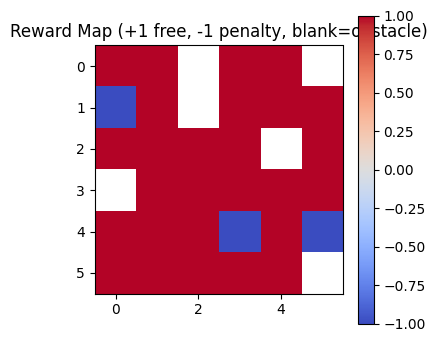

Theoretical (soft) positive-sum of free cells: 27.0

Training agents (light-weight)...


/tmp/ipython-input-259502483.py:116: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return a.item(), dist.log_prob(torch.tensor(a))


Step 1/150 | MPO loss=0.6588 | PMPO loss=0.4669 | DPO loss=1.4584
Step 25/150 | MPO loss=0.3560 | PMPO loss=0.0001 | DPO loss=0.0016
Step 50/150 | MPO loss=0.6460 | PMPO loss=0.0000 | DPO loss=0.0000
Step 75/150 | MPO loss=0.5744 | PMPO loss=0.0000 | DPO loss=0.0000
Step 100/150 | MPO loss=0.6418 | PMPO loss=0.0000 | DPO loss=0.0000
Step 125/150 | MPO loss=0.5227 | PMPO loss=-0.0000 | DPO loss=0.0000
Step 150/150 | MPO loss=0.5871 | PMPO loss=-0.0000 | DPO loss=0.0000
PMPO avg reward (5 eps): -7.600
MPO avg reward (5 eps): 6.600
DPO avg reward (5 eps): 3.000
Baseline avg reward (5 eps): 8.600


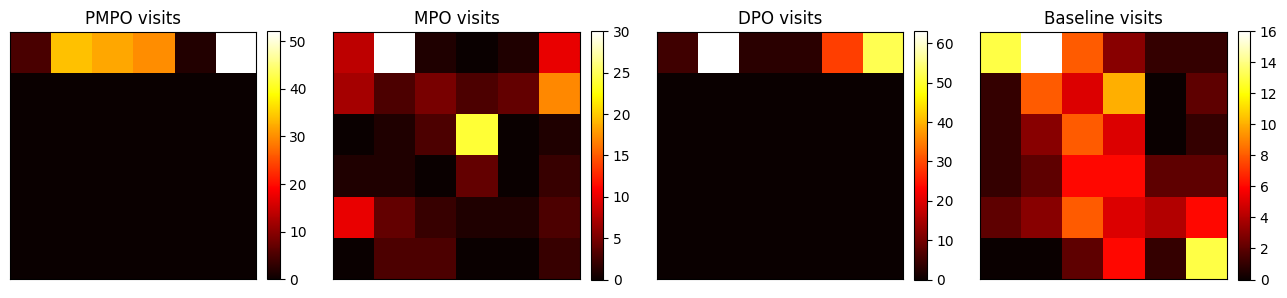


Animating first episode from each agent (side-by-side)...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


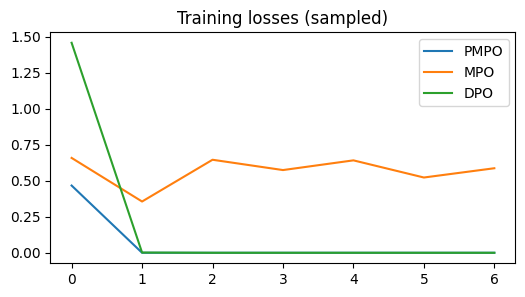


Done. avg_rewards: {'PMPO': -7.6, 'MPO': 6.6, 'DPO': 3.0, 'Baseline': 8.6}


In [ ]:
policies, avg_rewards, heatmaps = run_full_showdown(seed=42)
print("\nDone. avg_rewards:", avg_rewards)

## Work in Progress - All models side by side on same 10x10 grid map with random weights (+5 to -3)

Fixed reward map (NaN = obstacle):
 [[ 3.  0.  4.  1. nan nan  3.  4.  1.  0.]
 [ 4.  4. nan  2. nan nan  4.  2. nan  1.]
 [-3.  2.  5. -3. -1.  3.  0.  5. nan nan]
 [nan  3. nan  5.  3. -2. nan  5. -2.  5.]
 [ 1. -2.  0.  3.  4. -1. -3.  0. -2.  4.]
 [ 0. -2.  2.  2.  0. nan -2. -2.  0.  4.]
 [ 3.  5.  4.  1. -2. nan  4.  5.  5. -3.]
 [nan  3. nan  4. -3.  4. nan -1. nan  4.]
 [-1. -1. nan  1.  3.  5.  3. nan  4. -2.]
 [-3.  3.  3.  4.  1. nan  4.  2. -1. -3.]]

Upper-bound (sum of rewards on reachable cells): 119.00



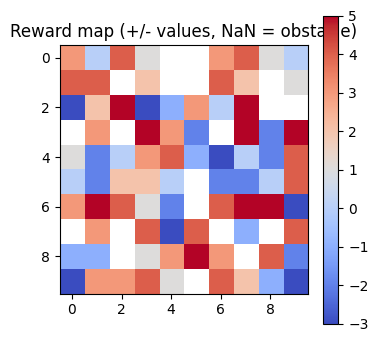

Training agents (lightweight)...
Train step 1/300 | MPO_loss=1.1085 | PMPO_loss=0.6958 | DPO_loss=1.4485
Train step 51/300 | MPO_loss=1.0428 | PMPO_loss=0.4809 | DPO_loss=0.7713
Train step 101/300 | MPO_loss=1.0273 | PMPO_loss=0.5478 | DPO_loss=0.7403
Train step 151/300 | MPO_loss=0.8627 | PMPO_loss=0.4618 | DPO_loss=0.7622
Train step 201/300 | MPO_loss=0.8752 | PMPO_loss=0.5244 | DPO_loss=0.7887
Train step 251/300 | MPO_loss=0.9289 | PMPO_loss=0.3623 | DPO_loss=0.4230
Train step 300/300 | MPO_loss=0.7808 | PMPO_loss=0.2743 | DPO_loss=0.4333
PMPO avg_reward (over 5 eps): 1.000
MPO avg_reward (over 5 eps): 36.000
DPO avg_reward (over 5 eps): 10.600
Baseline avg_reward (over 5 eps): 52.400


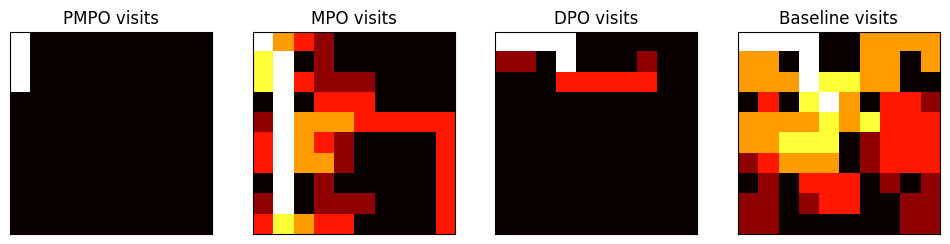


Animating (first episode for each agent) — side by side:


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)



--- Summary ---
Theoretical reachable sum (upper bound if visiting all reachable cells): 119.00
PMPO average collected reward (over 5 episodes): 1.000
MPO average collected reward (over 5 episodes): 36.000
DPO average collected reward (over 5 episodes): 10.600
Baseline average collected reward (over 5 episodes): 52.400


In [17]:
# Colab-ready: PMPO vs MPO vs DPO vs Baseline on a fixed 10x10 map
# Paste into a single Colab cell and run.

import torch, random, math
import torch.nn as nn, torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, display

def safe_softmax(x, dim=-1, eps=1e-6):
    # subtract max for stability
    x = x - x.max()
    ex = torch.exp(x)
    ex = ex + eps       # avoid zeros
    return ex / ex.sum(dim=dim, keepdim=True)



# -------------------------
# Environment: fixed map generator + env that uses it
# -------------------------
class FixedMap:
    def __init__(self, size=10, obstacle_frac=0.2, seed=0):
        self.size = size
        self.obstacle_frac = obstacle_frac
        self.seed = seed
        self._make_map()

    def _make_map(self):
        np.random.seed(self.seed)
        random.seed(self.seed)
        S = self.size
        total = S * S
        num_obstacles = int(math.floor(self.obstacle_frac * total))

        # initialize all cells as traversable
        self.obstacles = np.zeros((S, S), dtype=bool)

        # ensure start and goal are never obstacles
        coords = [(i, j) for i in range(S) for j in range(S) if (i, j) not in [(0, 0), (S-1, S-1)]]
        chosen = random.sample(coords, num_obstacles)
        for (x, y) in chosen:
            self.obstacles[x, y] = True

        # reward values for traversable cells: random integers in [-3..5]
        # obstacles will be NaN in reward_map
        vals = np.random.randint(-3, 6, size=(S, S))
        vals[self.obstacles] = 0  # placeholder
        self.reward_map = vals.astype(float)
        self.reward_map[self.obstacles] = np.nan

    def get_reward_map(self):
        return self.reward_map.copy()

    def is_obstacle(self, x, y):
        return self.obstacles[x, y]

    def reachable_cells_sum(self):
        # BFS from (0,0) avoiding obstacles => sum of rewards on reachable cells
        S = self.size
        visited = np.zeros((S, S), dtype=bool)
        from collections import deque
        q = deque()
        if not self.obstacles[0, 0]:
            q.append((0, 0))
            visited[0, 0] = True
        while q:
            x, y = q.popleft()
            for dx, dy in [(-1,0),(1,0),(0,-1),(0,1)]:
                nx, ny = x+dx, y+dy
                if 0 <= nx < S and 0 <= ny < S and (not visited[nx, ny]) and (not self.obstacles[nx, ny]):
                    visited[nx, ny] = True
                    q.append((nx, ny))
        # sum positive cells reachable (upper bound if you could visit all positives)
        reachable_rewards = self.reward_map.copy()
        reachable_rewards[~visited] = 0
        return reachable_rewards.sum(), visited

# -------------------------
# Environment wrapper used for rollouts (shares fixed map)
# -------------------------
class MapEnv:
    def __init__(self, fixed_map: FixedMap):
        self.map = fixed_map
        self.size = fixed_map.size
        self.reset()

    def reset(self):
        self.agent_pos = [0, 0]
        self.visited = np.zeros((self.size, self.size), dtype=int)
        self.visited[0, 0] = 1
        self.total_reward = 0.0
        return self._get_observation()

    def _get_observation(self):
        # simple flattened observation encoding: visited(1), obstacle(-2), penalty(-1), agent(2)
        S = self.size
        obs = np.zeros((S, S), dtype=float)
        obs[self.visited == 1] = 1.0
        obs[self.map.obstacles] = -2.0
        # we don't encode reward values directly in observation (agent must learn)
        x, y = self.agent_pos
        obs[x, y] = 2.0
        return torch.tensor(obs.flatten(), dtype=torch.float32)

    def step(self, action):
        x, y = self.agent_pos
        new_x, new_y = x, y
        if action == 0 and x > 0: new_x -= 1
        elif action == 1 and x < self.size - 1: new_x += 1
        elif action == 2 and y > 0: new_y -= 1
        elif action == 3 and y < self.size - 1: new_y += 1

        # if obstacle, agent stays
        if self.map.is_obstacle(new_x, new_y):
            new_x, new_y = x, y

        self.agent_pos = [new_x, new_y]

        # reward defined by map (once per first visit)
        r = 0.0
        if self.visited[new_x, new_y] == 0:
            # reward_map has NaN for obstacles, but we can't be on obstacles
            r = float(self.map.reward_map[new_x, new_y])
        self.visited[new_x, new_y] = 1
        self.total_reward += r
        done = (new_x == self.size-1 and new_y == self.size-1)
        return self._get_observation(), r, done

# -------------------------
# Policy net (shared)
# -------------------------
class MapPolicy(nn.Module):
    def __init__(self, size):
        super().__init__()
        D = size * size
        self.net = nn.Sequential(
            nn.Linear(D, 128),
            nn.ReLU(),
            nn.Linear(128, 4)
        )

    def forward(self, obs):
        logits = self.net(obs.float())
        return torch.softmax(logits, dim=-1)

    def sample_action(self, obs):
        probs = self.forward(obs)
        dist = torch.distributions.Categorical(probs)
        a = dist.sample()
        return int(a.item()), dist.log_prob(a)

# -------------------------
# Trajectory generator that ends only at goal or max_steps
# -------------------------
def generate_trajectory(env: MapEnv, policy: MapPolicy, max_steps=400):
    obs = env.reset()
    states, actions, rewards = [], [], []
    frames = []
    for _ in range(max_steps):
        a, _ = policy.sample_action(obs)
        obs, r, done = env.step(a)
        states.append(obs.clone())
        actions.append(a)
        rewards.append(r)
        # prepare frame array: -2=obstacle, -1=negative cell, 0=unvisited, 1=visited, 2=agent
        frame = np.zeros((env.size, env.size), dtype=float)
        frame[env.map.obstacles] = -2
        # mark visited
        frame[env.visited == 1] = 1.0
        ax, ay = env.agent_pos
        frame[ax, ay] = 2.0
        frames.append(frame)
        if done:
            break
    traj = {
        'states': states,
        'actions': actions,
        'rewards': rewards,
        'total_reward': sum(rewards),
        'frames': frames,
        'visited': env.visited.copy()
    }
    return traj

# -------------------------
# Preference oracle (noisy)
# -------------------------
def preference_oracle(t1, t2, noise=0.1):
    s1 = t1['total_reward'] + np.random.normal(0, noise)
    s2 = t2['total_reward'] + np.random.normal(0, noise)
    if s1 > s2: return 1
    if s2 > s1: return -1
    return 0

# -------------------------
# Simplified MPO / PMPO / DPO updates (educational)
# -------------------------
def mpo_update(policy: MapPolicy, trajs, optimizer, eta=0.5):
    # Build approximate state-action Q by averaging returns for occurrences
    state_action_values = {}
    for traj in trajs:
        # compute returns
        returns = []
        G = 0.0
        for r in reversed(traj['rewards']):
            G = r + G
            returns.insert(0, G)
        for s_tensor, a, Gt in zip(traj['states'], traj['actions'], returns):
            key = tuple(s_tensor.numpy().round(6).tolist())
            if key not in state_action_values: state_action_values[key] = {}
            state_action_values[key].setdefault(a, []).append(Gt)

    # KL loss
    loss_total = 0.0
    count = 0
    for key, a_dict in state_action_values.items():
        Qs = torch.full((4,), -1e6)
        for a, vals in a_dict.items():
            Qs[a] = float(np.mean(vals))
        # reconstruct state
        state_np = np.array(key, dtype=np.float32)
        state_t = torch.tensor(state_np)
        with torch.no_grad():
            pi = policy.forward(state_t)
            # replace -1e6 with min to avoid overflow
            Qs_clipped = torch.where(Qs < -1e5, torch.tensor(-1000.0), Qs)
            q = safe_softmax(torch.log(pi + 1e-8) + Qs_clipped / eta)
            if q.sum() <= 0: continue
            q = q / q.sum()
        pi = policy.forward(state_t)
        kl = torch.sum(q * (torch.log(q + 1e-8) - torch.log(pi + 1e-8)))
        loss_total += kl
        count += 1
    if count == 0:
        return 0.0
    loss = loss_total / count
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return float(loss.item())

def pmpo_update(policy: MapPolicy, pref_pairs, optimizer, eta=0.5):
    # accumulate preference scores per state-action
    state_scores = {}
    for t1, t2, label in pref_pairs:
        preferred = None
        if label == 1: preferred = t1
        elif label == -1: preferred = t2
        if preferred is None: continue
        for s_tensor, a in zip(preferred['states'], preferred['actions']):
            key = tuple(s_tensor.numpy().round(6).tolist())
            state_scores.setdefault(key, np.zeros(4, dtype=float))[a] += 1.0

    # KL loss similar to MPO but using scores as pseudo-Q
    loss_total = 0.0
    count = 0
    for key, scores in state_scores.items():
        state_np = np.array(key, dtype=np.float32)
        state_t = torch.tensor(state_np)
        with torch.no_grad():
            pi = policy.forward(state_t)
            scores_t = torch.tensor(scores, dtype=torch.float32)
            q = safe_softmax(torch.log(pi + 1e-8) + scores_t / eta)
            if q.sum() <= 0: continue
            q = q / q.sum()
        pi = policy.forward(state_t)
        kl = torch.sum(q * (torch.log(q + 1e-8) - torch.log(pi + 1e-8)))
        loss_total += kl
        count += 1
    if count == 0:
        return 0.0
    loss = loss_total / count
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return float(loss.item())

def dpo_update(policy: MapPolicy, pref_pairs, optimizer):
    # maximize likelihood of actions in preferred trajectories
    loss_total = 0.0
    count = 0
    for t1, t2, label in pref_pairs:
        preferred = None
        if label == 1: preferred = t1
        elif label == -1: preferred = t2
        if preferred is None: continue
        for s_tensor, a in zip(preferred['states'], preferred['actions']):
            state_np = np.array(tuple(s_tensor.numpy().round(6).tolist()), dtype=np.float32)
            state_t = torch.tensor(state_np)
            pi = policy.forward(state_t)
            l = -torch.log(pi[a] + 1e-8)
            loss_total += l
            count += 1
    if count == 0:
        return 0.0
    loss = loss_total / count
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return float(loss.item())

# -------------------------
# Training harness
# -------------------------
def train_all_on_fixed_map(fmap: FixedMap, TRAIN_STEPS=300, TRAJ_PER_STEP=8, MAX_TRAJ_LEN=200):
    # create policies
    policies = {
        'PMPO': MapPolicy(fmap.size),
        'MPO': MapPolicy(fmap.size),
        'DPO': MapPolicy(fmap.size),
        'Baseline': MapPolicy(fmap.size)  # baseline left untrained (random)
    }
    opt = {
        'PMPO': optim.Adam(policies['PMPO'].parameters(), lr=1e-2),
        'MPO':  optim.Adam(policies['MPO'].parameters(), lr=1e-2),
        'DPO':  optim.Adam(policies['DPO'].parameters(), lr=1e-2),
        'Baseline': None
    }
    logs = {'PMPO': [], 'MPO': [], 'DPO': []}

    for step in range(TRAIN_STEPS):
        # MPO trajectories (reward-based) generated on copies of the same fixed map
        mpo_trajs = []
        for _ in range(TRAJ_PER_STEP):
            env = MapEnv(fmap)
            mpo_trajs.append(generate_trajectory(env, policies['MPO'], max_steps=MAX_TRAJ_LEN))

        # Preference pairs generated using PMPO policy interacting with same fixed map instances
        pref_pairs = []
        for _ in range(TRAJ_PER_STEP):
            e1 = MapEnv(fmap)
            e2 = MapEnv(fmap)
            t1 = generate_trajectory(e1, policies['PMPO'], max_steps=MAX_TRAJ_LEN)
            t2 = generate_trajectory(e2, policies['PMPO'], max_steps=MAX_TRAJ_LEN)
            pref_pairs.append((t1, t2, preference_oracle(t1, t2, noise=0.2)))

        # updates
        l_mpo = mpo_update(policies['MPO'], mpo_trajs, opt['MPO'], eta=0.5)
        l_pmpo = pmpo_update(policies['PMPO'], pref_pairs, opt['PMPO'], eta=0.5)
        l_dpo = dpo_update(policies['DPO'], pref_pairs, opt['DPO'])

        if step % 50 == 0 or step == TRAIN_STEPS-1:
            print(f"Train step {step+1}/{TRAIN_STEPS} | MPO_loss={l_mpo:.4f} | PMPO_loss={l_pmpo:.4f} | DPO_loss={l_dpo:.4f}")

        logs['MPO'].append(l_mpo)
        logs['PMPO'].append(l_pmpo)
        logs['DPO'].append(l_dpo)

    return policies, logs

# -------------------------
# Evaluation, heatmaps and animation
# -------------------------
def evaluate_policy_on_map(fmap: FixedMap, policy: MapPolicy, episodes=3, max_steps=400):
    total_rewards = []
    cumulative_visits = np.zeros((fmap.size, fmap.size), dtype=int)
    first_episode_frames = None
    for ep in range(episodes):
        env = MapEnv(fmap)
        traj = generate_trajectory(env, policy, max_steps=max_steps)
        total_rewards.append(traj['total_reward'])
        cumulative_visits += traj['visited']
        if first_episode_frames is None:
            first_episode_frames = traj['frames']
    return float(np.mean(total_rewards)), cumulative_visits, first_episode_frames

def pad_frames(frames, length):
    # frames is list of arrays; pad by repeating last frame
    if frames is None: return [np.zeros((10,10)) for _ in range(length)]
    out = frames.copy()
    while len(out) < length:
        out.append(out[-1].copy())
    return out

def side_by_side_animation(frames_dict, names, interval=350):
    # ensure same length by padding to max
    max_len = max(len(frames_dict[n]) for n in names)
    for n in names:
        frames_dict[n] = pad_frames(frames_dict[n], max_len)

    n = len(names)
    fig, axes = plt.subplots(1, n, figsize=(4*n, 4))
    cmap = colors.ListedColormap(['black', 'red', 'lightgray', 'yellow', 'blue'])
    bounds = [-2.5, -1.5, -0.5, 0.5, 1.5, 2.5]
    norm = colors.BoundaryNorm(bounds, cmap.N)
    ims = []
    for i, nm in enumerate(names):
        axes[i].set_title(nm)
        axes[i].set_xticks([]); axes[i].set_yticks([])
        im = axes[i].imshow(frames_dict[nm][0], cmap=cmap, norm=norm)
        ims.append(im)

    def update(idx):
        for i, nm in enumerate(names):
            ims[i].set_data(frames_dict[nm][idx])
        return ims

    ani = FuncAnimation(fig, update, frames=max_len, interval=interval, blit=True)
    plt.close(fig)
    return ani

# -------------------------
# Run everything: create fixed map, train, eval, animate
# -------------------------
def run_showdown(seed=123):
    # config
    SIZE = 10
    OB_FRACT = 0.2
    TRAIN_STEPS = 300      # adjust for runtime/quality
    TRAJ_PER_STEP = 6
    MAX_TRAJ_LEN = 300
    EVAL_EPISODES = 5

    fmap = FixedMap(size=SIZE, obstacle_frac=OB_FRACT, seed=seed)
    rm = fmap.get_reward_map()
    reachable_sum, reachable_mask = fmap.reachable_cells_sum()

    print("Fixed reward map (NaN = obstacle):\n", rm)
    print(f"\nUpper-bound (sum of rewards on reachable cells): {reachable_sum:.2f}\n")

    # display reward map
    plt.figure(figsize=(4,4))
    plt.title("Reward map (+/- values, NaN = obstacle)")
    plt.imshow(rm, cmap='coolwarm', origin='upper')
    plt.colorbar()
    plt.show()

    # train
    print("Training agents (lightweight)...")
    policies, logs = train_all_on_fixed_map(fmap, TRAIN_STEPS, TRAJ_PER_STEP, MAX_TRAJ_LEN)

    # evaluate
    names = ['PMPO', 'MPO', 'DPO', 'Baseline']
    avg_rewards = {}
    heatmaps = {}
    frames_dict = {}
    for n in names:
        if n == 'Baseline':
            pol = MapPolicy(fmap.size)  # random
        else:
            pol = policies[n]
        ar, hm, frames = evaluate_policy_on_map(fmap, pol, episodes=EVAL_EPISODES, max_steps=MAX_TRAJ_LEN)
        avg_rewards[n] = ar
        heatmaps[n] = hm
        frames_dict[n] = frames
        print(f"{n} avg_reward (over {EVAL_EPISODES} eps): {ar:.3f}")

    # display heatmaps
    plt.figure(figsize=(12,3))
    for i, n in enumerate(names):
        plt.subplot(1,4,i+1)
        plt.imshow(heatmaps[n], cmap='hot')
        plt.title(f"{n} visits")
        plt.xticks([]); plt.yticks([])
    plt.show()

    # animate side-by-side (Colab inline)
    print("\nAnimating (first episode for each agent) — side by side:")
    ani = side_by_side_animation(frames_dict, names, interval=250)
    display(HTML(ani.to_jshtml()))

    # print collected rewards and upper bound
    print("\n--- Summary ---")
    print(f"Theoretical reachable sum (upper bound if visiting all reachable cells): {reachable_sum:.2f}")
    for n in names:
        print(f"{n} average collected reward (over {EVAL_EPISODES} episodes): {avg_rewards[n]:.3f}")
    return policies, avg_rewards, heatmaps, fmap

# Run
policies, avg_rewards, heatmaps, fmap = run_showdown(seed=42)
